# plot

> Accurate and interative big data visualization

In [ ]:
#| default_exp cli/plot

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import holoviews as hv
from holoviews import opts
import numpy as np
from bokeh.models import WheelZoomTool
import moraine.cli as mc

In [ ]:
#| export
import logging
import zarr
import numpy as np
import math
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import sys
from functools import partial
from typing import Callable
import numpy as np
from numba import prange
import holoviews as hv
from holoviews import streams

import toml
from moraine.utils_ import ngpjit
from moraine.rtree import HilbertRtree
from moraine.cli.logging import mc_logger
from moraine.coord_ import Coord

In [ ]:
#| export
#| hide
def zarr_stack_info(zarr_path_list, #list of zarr path
                   ):
    shape_list = []; chunks_list = []; dtype_list = []
    for zarr_path in zarr_path_list:
        zarr_data = zarr.open(zarr_path,'r')
        shape_list.append(zarr_data.shape)
        chunks_list.append(zarr_data.chunks)
        dtype_list.append(zarr_data.dtype)
    df = pd.DataFrame({'path':zarr_path_list,'shape':shape_list,'chunks':chunks_list,'dtype':dtype_list})
    return df

## raster plot

In [ ]:
#| export
@mc_logger
def ras_pyramid(ras:str, # path to input data, 2D zarr array (one single raster) or 3D zarr array (a stack of rasters)
                out_dir:str, # output directory to store rendered data
                ):
    '''render raster data to pyramid of difference zoom levels.'''
    logger = logging.getLogger(__name__)
    out_dir = Path(out_dir); out_dir.mkdir(exist_ok=True)
    ras_zarr = zarr.open(ras,'r')
    logger.zarr_info(ras, ras_zarr)
    
    ny, nx = ras_zarr.shape[0:2]
    maxlevel = math.floor(math.log2(min(nx,ny))) # so at least 2 pixels
    logger.info(f'rendered raster pyramid with zoom level ranging from 0 (finest resolution) to {maxlevel} (coarsest resolution).')

    ndim = ras_zarr.ndim
    o_zarr_path_list = []; o_zarr_list = []
    for level in range(maxlevel+1):
        if ndim == 3:
            shape = (math.ceil(ny/(2**level)), math.ceil(nx/(2**level)), ras_zarr.shape[2])
            chunks = (256, 256, 1)
        elif ndim == 2:
            shape = (math.ceil(ny/(2**level)), math.ceil(nx/(2**level)))
            chunks = (256, 256)
        else:
            raise ValueError('ndim of input should be 2 or 3.')
        o_zarr_path = out_dir/f'{level}.zarr'
        o_zarr = zarr.open(zarr.NestedDirectoryStore(o_zarr_path),
                           'w',shape=shape,chunks=chunks,dtype=ras_zarr.dtype)
        o_zarr_path_list.append(o_zarr_path); o_zarr_list.append(o_zarr)

    df_disp = zarr_stack_info(o_zarr_path_list)
    logger.info(f'pyramid to be rendered: \n {df_disp}')
    
    logger.info(f'pyramid rendering starts.')
    if ndim == 2:
        ras_data = ras_zarr[:]
        for level in tqdm(range(maxlevel+1),file=sys.stdout,desc='Tiles'):
            o_zarr_list[level][:,:] = ras_data[::2**level,::2**level]
    else:
        for i in tqdm(range(ras_zarr.shape[2]),file=sys.stdout,desc='Images'):
            ras_data = ras_zarr[:,:,i]
            for level in range(maxlevel+1):
            # for level in tqdm(range(maxlevel+1),file=sys.stdout,desc='Tiles',position=0):
                o_zarr_list[level][:,:,i] = ras_data[::2**level,::2**level]
    logger.info(f'tiles rendering finished.')

[`ras_pyramid`](#ras_pyramid) render one single raster (2D array) or a stack of rasters (2D array) into tiles of difference resolution (zoom level).

In [ ]:
adi = 'plot/adi.zarr'
rslc = 'plot/rslc.zarr'
adi_pyramid_dir = 'plot/adi_pyramid'
rslc_pyramid_dir = 'plot/rslc_pyramid'

In [ ]:
logger = mc.get_logger()

In [ ]:
ras_pyramid(adi,adi_pyramid_dir)

2024-04-30 22:36:10 - log_args - INFO - running function: ras_pyramid
2024-04-30 22:36:10 - log_args - INFO - fetching args:
2024-04-30 22:36:10 - log_args - INFO - ras = 'plot/adi.zarr'
2024-04-30 22:36:10 - log_args - INFO - out_dir = 'plot/adi_pyramid'
2024-04-30 22:36:10 - log_args - INFO - fetching args done.
2024-04-30 22:36:10 - zarr_info - INFO - plot/adi.zarr zarray shape: (2500, 1834)
2024-04-30 22:36:10 - zarr_info - INFO - plot/adi.zarr zarray chunks: (1000, 1000)
2024-04-30 22:36:10 - zarr_info - INFO - plot/adi.zarr zarray dtype: float32
2024-04-30 22:36:10 - ras_pyramid - INFO - rendered raster pyramid with zoom level ranging from 0 (finest resolution) to 10 (coarsest resolution).
2024-04-30 22:36:10 - ras_pyramid - INFO - pyramid to be rendered: 
                         path         shape      chunks    dtype
0    plot/adi_pyramid/0.zarr  (2500, 1834)  (256, 256)  float32
1    plot/adi_pyramid/1.zarr   (1250, 917)  (256, 256)  float32
2    plot/adi_pyramid/2.zarr    (6

In [ ]:
ras_pyramid(rslc,rslc_pyramid_dir)

2024-04-30 22:36:12 - log_args - INFO - running function: ras_pyramid
2024-04-30 22:36:12 - log_args - INFO - fetching args:
2024-04-30 22:36:12 - log_args - INFO - ras = 'plot/rslc.zarr'
2024-04-30 22:36:12 - log_args - INFO - out_dir = 'plot/rslc_pyramid'
2024-04-30 22:36:12 - log_args - INFO - fetching args done.
2024-04-30 22:36:12 - zarr_info - INFO - plot/rslc.zarr zarray shape: (2500, 1834, 17)
2024-04-30 22:36:12 - zarr_info - INFO - plot/rslc.zarr zarray chunks: (1000, 1000, 1)
2024-04-30 22:36:12 - zarr_info - INFO - plot/rslc.zarr zarray dtype: complex64
2024-04-30 22:36:12 - ras_pyramid - INFO - rendered raster pyramid with zoom level ranging from 0 (finest resolution) to 10 (coarsest resolution).
2024-04-30 22:36:13 - ras_pyramid - INFO - pyramid to be rendered: 
                          path             shape         chunks      dtype
0    plot/rslc_pyramid/0.zarr  (2500, 1834, 17)  (256, 256, 1)  complex64
1    plot/rslc_pyramid/1.zarr   (1250, 917, 17)  (256, 256, 1)  

In [ ]:
#| export
#| hide
def hv_ras_callback(x_range,y_range,width,height,scale,data_dir,post_proc,coord):
    # start = time.time()
    if x_range is None:
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if y_range is None:
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res,y_res)))
    level = sorted((0, level, coord.maxlevel))[1]
    data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
    xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
    coord_bbox = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
    # decide_slice = time.time()
    # print(f"It takes {decide_slice-start} to decide the data range", file = sourceFile) 
    data = data_zarr[yi0:yim+1,xi0:xim+1]
    # load_data = time.time()
    # print(f"It takes {load_data-decide_slice} to load the data", file = sourceFile) 
    data = post_proc(data)
    # post_proc_data = time.time()
    # print(f"It takes {post_proc_data-load_data} to post_proc the data", file = sourceFile)
    ### test shows data read takes only 0.006 s, post_proc and data_range takes only 0.001s
    ### the majority of time is used by holoviews that I can not optimize.
    return hv.Image(data[::-1,:],bounds=coord_bbox)

In [ ]:
#| export
def ras_plot(rendered_tiles_dir:str, # directory to the rendered images
             post_proc:Callable=None, # function for the post processing
             bounds:tuple=None, # bounding box (x0, y0, x_max, y_max)
            ):
    '''plot rendered ras tiles.'''
    rendered_tiles_dir = Path(rendered_tiles_dir)
    data_zarr = zarr.open(rendered_tiles_dir/'0.zarr','r')
    ny, nx = data_zarr.shape
    
    if post_proc is None: post_proc = lambda x: x
    if bounds is None:
        x0 = 0; dx = 1; y0 = 0; dy = 1
    else:
        x0, y0, xm, ym = bounds
        dx = (xm-x0)/(nx-1); dy = (ym-y0)/(ny-1)
    coord = Coord(x0,dx,nx,y0,dy,ny)
    
    rangexy = streams.RangeXY()
    plotsize = streams.PlotSize()
    images = hv.DynamicMap(partial(hv_ras_callback,data_dir=rendered_tiles_dir,post_proc=post_proc,coord=coord),streams=[rangexy,plotsize])
    return images

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
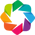

In [ ]:
hv.extension('bokeh')

`ras_plot` take the rendered tiles as the input and return a Holoviews `DynamicMap`.
It accept a post processing function for customized post processing.
Here we define a function to mask pixels with ADI larger than 0.4:

In [ ]:
def mask_adi(data:np.array,):
    data[data>=0.4]=np.nan
    return data

In [ ]:
adi_plot = ras_plot(adi_pyramid_dir,post_proc=mask_adi,bounds=(0,0,1833,2499))

Add annotations:

In [ ]:
adi_plot = adi_plot.redim(x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'),
                          z=hv.Dimension('adi',label='Amplitude Dispersion Index',range=(0,0.4)))

Specify plotting options and plot:

In [ ]:
adi_plot.opts(opts.Image(cmap='fire',width=600, height=400, colorbar=True,
                         invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        ))

:DynamicMap   []
   :Image   [r,az]   (adi)

![Raster Plot](./plot/raster_plot.gif)

In [ ]:
#| export
#| hide
def hv_ras_stack_callback(x_range,y_range,width,height,scale,data_dir,post_proc,coord,i=0):
    if x_range is None:
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if y_range is None:
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res,y_res)))
    level = sorted((0, level, coord.maxlevel))[1]
    data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
    xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
    coord_bbox = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
    data = post_proc(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1),i)
    return hv.Image(data[::-1,:],bounds=coord_bbox)

In [ ]:
#| export
def ras_stack_plot(rendered_tiles_dir:str, # directory to the rendered images
                   post_proc:Callable=None, # function for the post processing
                   bounds:tuple=None, # bounding box (x0, y0, x_max, y_max)
                  ):
    '''plot rendered stack of ras tiles.'''
    rendered_tiles_dir = Path(rendered_tiles_dir)
    data_zarr = zarr.open(rendered_tiles_dir/'0.zarr','r')
    ny, nx = data_zarr.shape[:2]
    
    if post_proc is None: post_proc = lambda data_zarr,x_slice,y_slice,i: data_zarr[y_slice,x_slice,i]
    if bounds is None:
        x0 = 0; dx = 1; y0 = 0; dy = 1
    else:
        x0, y0, xm, ym = bounds
        dx = (xm-x0)/(nx-1); dy = (ym-y0)/(ny-1)
    coord = Coord(x0,dx,nx,y0,dy,ny)
    
    rangexy = streams.RangeXY()
    plotsize = streams.PlotSize()
    images = hv.DynamicMap(partial(hv_ras_stack_callback,data_dir=rendered_tiles_dir,post_proc=post_proc,coord=coord),streams=[rangexy,plotsize],kdims='i')
    return images

`ras_stack_plot` take the rendered images as the input and return a Holoviews `DynamicMap`.
It accept a post processing function for customized post processing.
Here we define a function to generate interferograms w.r.t the first SLC:

In [ ]:
def intf_0(data_zarr, xslice, yslice,i):
    return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,0].conj())

In [ ]:
intf_plot = ras_stack_plot(rslc_pyramid_dir,post_proc=intf_0)

Add annotations:

In [ ]:
dates = ["20210802", "20210816", "20210830", "20210913", "20211011", "20211025", "20220606", "20220620",
         "20220704", "20220718", "20220801", "20220815", "20220829", "20220912", "20220926", "20221010",
         "20221024",]
intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Interferogram', range=(0,16), value_format=(lambda i: dates[i]+'_'+dates[0])),
                            x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))

Specify plotting options and plot:

In [ ]:
hv.output(widget_location='bottom')
intf_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
                          invert_yaxis=True,
                          default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],active_tools=['wheel_zoom']))

:DynamicMap   [i]
   :Image   [r,az]   (Phase)

![Raster Stack Plot](./plot/raster_stack_plot.gif)

We can also plot sequential interferograms. In this case, we only plot 26 interferograms.

In [ ]:
def intf_seq(data_zarr, xslice, yslice,i):
    return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,i-1].conj())
intf_plot = ras_stack_plot(rslc_pyramid_dir,post_proc=intf_seq)
intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Interferogram', range=(1,16), value_format=(lambda i: dates[i]+'_'+dates[i-1])),
                            x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))
intf_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
                          invert_yaxis=True, default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                          active_tools=['wheel_zoom']))

:DynamicMap   [i]
   :Image   [r,az]   (Phase)

Or the intensity:

In [ ]:
def intensity(data_zarr, xslice, yslice,i):
    return np.log(np.abs(data_zarr[yslice,xslice,i])**2)

int_plot = ras_stack_plot(rslc_pyramid_dir,post_proc=intensity)
int_plot = int_plot.redim(i=hv.Dimension('i', label='Intensity', range=(1,16), value_format=(lambda i: dates[i])),
                          x=hv.Dimension('r', label='Range'), y=hv.Dimension('az',label='Azimuth'), z=hv.Dimension('Intensity'))
int_plot.opts(opts.Image(cmap='gray',width=600, height=600, colorbar=True,
                         invert_yaxis=True, default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']))

:DynamicMap   [i]
   :Image   [r,az]   (Intensity)

## point cloud plot

In [ ]:
#| export
#| hide
@ngpjit
def _next_level_idx_from_raster_of_integer(pc_idx, nan_value):
    '''return the raster indices to the next level of raster'''
    assert pc_idx.ndim == 2
    ny, nx = pc_idx.shape
    next_ny, next_nx = math.ceil(ny/2), math.ceil(nx/2)
    xi = np.empty((next_ny,next_nx), dtype=np.int32)
    yi = np.empty((next_ny,next_nx), dtype=np.int32)

    for i in range(next_ny):
        for j in prange(next_nx):
            # Select a 2x2 box from the original array
            box = pc_idx[i*2:min(i*2+2, ny), j*2:min(j*2+2, nx)]
            idx_ = np.argwhere(box != nan_value)
            if len(idx_) == 0:
                yi[i,j]= i*2
                xi[i,j] = j*2
            else:
                yi[i,j] = idx_[0,0] + i*2
                xi[i,j] = idx_[0,1] + j*2
    return yi, xi

In [ ]:
#| export
#| hide
@ngpjit
def _next_level_idx_from_raster_of_noninteger(pc_data):
    '''return the raster indices to the next level of raster'''
    assert pc_data.ndim == 2
    ny, nx = pc_data.shape
    next_ny, next_nx = math.ceil(ny/2), math.ceil(nx/2)
    xi = np.empty((next_ny,next_nx), dtype=np.int32)
    yi = np.empty((next_ny,next_nx), dtype=np.int32)

    for i in range(next_ny):
        for j in prange(next_nx):
            # Select a 2x2 box from the original array
            box = pc_data[i*2:min(i*2+2, ny), j*2:min(j*2+2, nx)]
            idx_ = np.argwhere(~np.isnan(box))
            if len(idx_) == 0:
                yi[i,j]= i*2
                xi[i,j] = j*2
            else:
                yi[i,j] = idx_[0,0] + i*2
                xi[i,j] = idx_[0,1] + j*2
    return yi, xi

In [ ]:
#| hide
yi, xi = _next_level_idx_from_raster_of_integer(np.arange(10*10).reshape(10,10),0)
assert xi[0,0] == 1
np.testing.assert_array_equal(yi[:,0], np.arange(0,10,2))
np.testing.assert_array_equal(xi[1,:], np.arange(0,10,2))

In [ ]:
#| export
@mc_logger
def pc_pyramid(pc:str, # path to point cloud data, 1D array (one single pc image) or 2D zarr array (a stack of pc images)
               x:str, # path to x coordinate, e.g., longitude or web mercator x
               y:str, # path to y coordinate, e.g., latitude or web mercator y
               out_dir:str, # output directory to store rendered data
               ras_resolution:float=5, # minimum resolution of rendered raster data,
               ):
    '''render point cloud data to pyramid of difference zoom levels.'''
    logger = logging.getLogger(__name__)
    out_dir = Path(out_dir); out_dir.mkdir(exist_ok=True)
    pc_zarr = zarr.open(pc,'r')
    logger.zarr_info(pc, pc_zarr)
    
    n_pc = pc_zarr.shape[0]
    logger.info(f'rendering point cloud data coordinates:')
    x, y = zarr.open(x,'r')[:], zarr.open(y,'r')[:]
    o_x_zarr = zarr.open(out_dir/f'x.zarr','w',shape=x.shape, dtype=x.dtype, chunks=(256*256,))
    o_y_zarr = zarr.open(out_dir/f'y.zarr','w',shape=y.shape, dtype=y.dtype, chunks=(256*256,))
    o_x_zarr[:] = x; o_y_zarr[:]=y
    logger.info('pc data coordinates rendering ends.')

    x0, xm, y0, ym = x.min(), x.max(), y.min(), y.max()
    nx, ny = math.ceil((xm-x0)/ras_resolution), math.ceil((ym-y0)/ras_resolution)
    coord = Coord(x0, ras_resolution, nx, y0, ras_resolution, ny)
    bounds = {'bounds':[x0, y0, coord.xm, coord.ym]}
    logger.info(f"rasterizing point cloud data to grid with bounds: {bounds['bounds']}.")
    with open(out_dir/'bounds.toml','w') as f:
        toml.dump(bounds, f, encoder=toml.TomlNumpyEncoder())

    ndim = pc_zarr.ndim
    o_pc_zarr_path = out_dir/f'pc.zarr'
    o_pc_chunks = (256*256,1) if ndim == 2 else (256*256,)
    o_pc_zarr = zarr.open(o_pc_zarr_path,'w',shape=pc_zarr.shape,chunks=o_pc_chunks,dtype=pc_zarr.dtype)
    logger.info(f'pc pyramid pc part (level -1):')
    logger.zarr_info(o_pc_zarr_path, o_pc_zarr)

    gix = coord.coords2gixs((y,x)); del y; del x
    maxlevel = coord.maxlevel # so at least 2 pixels
    logger.info(f'rendered raster pyramid with zoom level ranging from 0 (finest resolution) to {maxlevel} (coarsest resolution).')

    ras_zarr_path_list = []; ras_zarr_list = []; ras_idx_zarr_path_list = []; ras_idx_zarr_list = []
    for level in range(maxlevel+1):
        shape = (math.ceil(ny/(2**level)), math.ceil(nx/(2**level)))
        chunks = (256, 256)
        ras_idx_zarr_path = out_dir/f'idx_{level}.zarr'
        ras_idx_zarr = zarr.open(zarr.NestedDirectoryStore(ras_idx_zarr_path),
                            'w',shape=shape,chunks=chunks,dtype=np.int64)
        ras_idx_zarr_path_list.append(ras_idx_zarr_path); ras_idx_zarr_list.append(ras_idx_zarr)
        if ndim == 2:
            shape = (math.ceil(ny/(2**level)), math.ceil(nx/(2**level)), pc_zarr.shape[1])
            chunks = (256, 256, 1)
        ras_zarr_path = out_dir/f'{level}.zarr'
        ras_zarr = zarr.open(zarr.NestedDirectoryStore(ras_zarr_path),
                            'w',shape=shape,chunks=chunks,dtype=pc_zarr.dtype)
        ras_zarr_path_list.append(ras_zarr_path); ras_zarr_list.append(ras_zarr)

    df_ras = zarr_stack_info(ras_zarr_path_list)
    logger.info(f'pc pyramid raster part to be rendered: \n {df_ras}')
    df_idx = zarr_stack_info(ras_idx_zarr_path_list)
    logger.info(f'pc pyramid index to be randered: \n {df_idx}')

    logger.info(f'pyramid raster indexing rendering starts.')
    current_idx = coord.rasterize_iidx(gix)
    next_yi_list = []; next_xi_list = []
    for level in tqdm(range(maxlevel+1),file=sys.stdout,desc='Tiles'):
        ras_idx_zarr_list[level][:] = current_idx
        next_yi, next_xi = _next_level_idx_from_raster_of_integer(current_idx,-1)
        next_yi_list.append(next_yi); next_xi_list.append(next_xi)
        current_idx = current_idx[next_yi, next_xi]

    logger.info(f'pyramid data rendering starts.')
    if ndim == 1:
        logger.info(f'pyramid pc part rendering starts.')
        pc_data = pc_zarr[:]
        o_pc_zarr[:] = pc_data; logger.info(f'pyramid pc part rendering ends.')
        logger.info(f'pyramid raster part rendering starts.')
        current_ras = coord.rasterize(pc_data, gix)
        for level in tqdm(range(maxlevel+1),file=sys.stdout,desc='Tiles'):
            ras_zarr_list[level][:,:] = current_ras
            current_ras = current_ras[next_yi_list[level],next_xi_list[level]]
    else:
        for i in tqdm(range(ras_zarr.shape[2]),file=sys.stdout,desc='Images'):
            pc_data = pc_zarr[:,i]
            o_pc_zarr[:,i] = pc_data
            current_ras = coord.rasterize(pc_data, gix)
            for level in range(maxlevel+1):
                ras_zarr_list[level][:,:,i] = current_ras
                current_ras = current_ras[next_yi_list[level],next_xi_list[level]]
    logger.info(f'pyramid rendering finished.')

`pc_pyramid` is a little bit more complex than `ras_pyramid`. The zoom level -1 is the point cloud data.
From zoom level 0 to above, the point cloud data is rasterize at different resolution.
`ras_resolution` is the parameter to set the resolution of zoom level 0.

In [ ]:
ps_can_adi = 'plot/pc/ps_can_adi.zarr/'
ps_can_rslc = 'plot/pc/ps_can_rslc.zarr/'
ps_can_x = './plot/pc/ps_can_e.zarr/'
ps_can_y = './plot/pc/ps_can_n.zarr/'
adi_pyramid_dir = 'plot/pc/adi_pyramid'
rslc_pyramid_dir = 'plot/pc/rslc_pyramid'

In [ ]:
pc_pyramid(ps_can_adi, ps_can_x, ps_can_y, adi_pyramid_dir, ras_resolution=20)

2024-04-30 22:36:43 - log_args - INFO - running function: pc_pyramid
2024-04-30 22:36:43 - log_args - INFO - fetching args:
2024-04-30 22:36:43 - log_args - INFO - pc = 'plot/pc/ps_can_adi.zarr/'
2024-04-30 22:36:43 - log_args - INFO - x = './plot/pc/ps_can_e.zarr/'
2024-04-30 22:36:43 - log_args - INFO - y = './plot/pc/ps_can_n.zarr/'
2024-04-30 22:36:43 - log_args - INFO - out_dir = 'plot/pc/adi_pyramid'
2024-04-30 22:36:43 - log_args - INFO - ras_resolution = 20
2024-04-30 22:36:43 - log_args - INFO - fetching args done.
2024-04-30 22:36:44 - zarr_info - INFO - plot/pc/ps_can_adi.zarr/ zarray shape: (43201,)
2024-04-30 22:36:44 - zarr_info - INFO - plot/pc/ps_can_adi.zarr/ zarray chunks: (10000,)
2024-04-30 22:36:44 - zarr_info - INFO - plot/pc/ps_can_adi.zarr/ zarray dtype: float32
2024-04-30 22:36:44 - pc_pyramid - INFO - rendering point cloud data coordinates:
2024-04-30 22:36:44 - pc_pyramid - INFO - pc data coordinates rendering ends.
2024-04-30 22:36:44 - pc_pyramid - INFO - r

In [ ]:
pc_pyramid(ps_can_rslc, ps_can_x, ps_can_y, rslc_pyramid_dir, ras_resolution=20)

2024-04-30 22:36:46 - log_args - INFO - running function: pc_pyramid
2024-04-30 22:36:46 - log_args - INFO - fetching args:
2024-04-30 22:36:46 - log_args - INFO - pc = 'plot/pc/ps_can_rslc.zarr/'
2024-04-30 22:36:46 - log_args - INFO - x = './plot/pc/ps_can_e.zarr/'
2024-04-30 22:36:46 - log_args - INFO - y = './plot/pc/ps_can_n.zarr/'
2024-04-30 22:36:46 - log_args - INFO - out_dir = 'plot/pc/rslc_pyramid'
2024-04-30 22:36:46 - log_args - INFO - ras_resolution = 20
2024-04-30 22:36:46 - log_args - INFO - fetching args done.
2024-04-30 22:36:46 - zarr_info - INFO - plot/pc/ps_can_rslc.zarr/ zarray shape: (43201, 17)
2024-04-30 22:36:46 - zarr_info - INFO - plot/pc/ps_can_rslc.zarr/ zarray chunks: (10000, 1)
2024-04-30 22:36:46 - zarr_info - INFO - plot/pc/ps_can_rslc.zarr/ zarray dtype: complex64
2024-04-30 22:36:46 - pc_pyramid - INFO - rendering point cloud data coordinates:
2024-04-30 22:36:46 - pc_pyramid - INFO - pc data coordinates rendering ends.
2024-04-30 22:36:46 - pc_pyrami

In [ ]:
#| export
#| hide
def is_nan_range(x_range):
    if x_range is None:
        return True
    if np.isnan(x_range[0]):
        return True
    return False

In [ ]:
#| hide
# def hv_image_pc(x_range,y_range,width,height,scale,data_dir,post_proc_ras,post_proc_pc,coord,rtree):
#     if is_nan_range(x_range):
#         x0 = coord.x0; xm = coord.xm
#         # pdb.set_trace()
#     else:
#         x0, xm = x_range
#         # pdb.set_trace()
#     if is_nan_range(y_range):
#         y0 = coord.y0; ym = coord.ym
#     else:
#         y0, ym = y_range
#     if height is None: height = hv.plotting.bokeh.ElementPlot.height
#     if width is None: width = hv.plotting.bokeh.ElementPlot.width

#     x_res = (xm-x0)/width; y_res = (ym-y0)/height
#     # pdb.set_trace()
#     level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
#     level = sorted((-1, level, coord.maxlevel))[1]
#     # level = -1
#     images = []
#     if level > -1:
#         data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
#         idx_zarr = zarr.open(data_dir/f'idx_{level}.zarr','r')
#         xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
#         x0, y0, xm, ym = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
#         data = data_zarr[yi0:yim+1,xi0:xim+1]
#         data = post_proc_ras(data)
#         idx = idx_zarr[yi0:yim+1,xi0:xim+1]
#         images.append(hv.Image((np.linspace(x0,xm,data.shape[1]), np.linspace(y0,ym,data.shape[0]),data,idx),vdims=['z','idx']))
#     else:
#         data_zarr, x_zarr, y_zarr = (zarr.open(data_dir/file,'r') for file in ('pc.zarr', 'x.zarr', 'y.zarr'))
#         idx = rtree.bbox_query((x0, y0, xm, ym), x_zarr, y_zarr)
#         data, x, y = (zarr_[idx] for zarr_ in (data_zarr, x_zarr, y_zarr))
#         # with open('out.txt', 'w') as f:
#         #     print(f'{level} \n{data}\n{idx}', file=f)  # Python 3.x
#         images.append(hv.Points((x,y,data,idx),vdims=['z','idx'])) #.opts(opts.Points(color='z'))
#     return hv.Overlay(images)

In [ ]:
#| hide
# def pc_plot(pyramid_dir:str, # directory to the rendered point cloud pyramid
#             post_proc_ras:Callable=None, # function for the post processing
#             post_proc_pc:Callable=None, # function for the post processing
#             rtree=None, # rtree
#            ):
#     '''plot rendered point cloud pyramid.'''    
#     if post_proc_ras is None: post_proc_ras = lambda x: x
#     if post_proc_pc is None: post_proc_pc = lambda x: x

#     pyramid_dir = Path(pyramid_dir)
#     data_zarr = zarr.open(pyramid_dir/'0.zarr','r')
#     ny, nx = data_zarr.shape
#     with open(pyramid_dir/'bounds.toml','r') as f:
#         x0, y0, xm, ym = toml.load(f)['bounds']

#     dx = (xm-x0)/(nx-1); dy = (ym-y0)/(ny-1)
#     coord = Coord(x0,dx,nx,y0,dy,ny)
    
#     if rtree is None:
#         x = zarr.open(pyramid_dir/'x.zarr','r')[:]
#         y = zarr.open(pyramid_dir/'y.zarr','r')[:]
#         rtree = HilbertRtree.build(x,y,page_size=512)
#     rangexy = streams.RangeXY()
#     plotsize = streams.PlotSize()
#     images = hv.DynamicMap(partial(hv_image_pc,data_dir=pyramid_dir,
#                                    post_proc_ras=post_proc_ras,post_proc_pc=post_proc_pc,
#                                    coord=coord,rtree=rtree),streams=[rangexy,plotsize])
#     return images

In [ ]:
#| export
#| hide
def hv_pc_Image_callback(x_range,y_range,width,height,scale,data_dir,post_proc_ras,coord):
    if is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level = sorted((-1, level, coord.maxlevel))[1]
    # level = -1
    images = []
    if level > -1:
        data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
        idx_zarr = zarr.open(data_dir/f'idx_{level}.zarr','r')
        xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
        x0, y0, xm, ym = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
        data = data_zarr[yi0:yim+1,xi0:xim+1]
        data = post_proc_ras(data)
        idx = idx_zarr[yi0:yim+1,xi0:xim+1]
        return hv.Image((np.linspace(x0,xm,data.shape[1]), np.linspace(y0,ym,data.shape[0]),data,idx),vdims=['z','idx'])
    else:
        return hv.Image([],vdims=['z','idx'])

In [ ]:
#| export
#| hide
def hv_pc_Points_callback(x_range,y_range,width,height,scale,data_dir,post_proc_pc,coord,rtree):
    if is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level = sorted((-1, level, coord.maxlevel))[1]
    # level = -1
    images = []
    if level > -1:
        return hv.Points([],vdims=['z','idx'])
    else:
        data_zarr, x_zarr, y_zarr = (zarr.open(data_dir/file,'r') for file in ('pc.zarr', 'x.zarr', 'y.zarr'))
        idx = rtree.bbox_query((x0, y0, xm, ym), x_zarr, y_zarr)
        data, x, y = (zarr_[idx] for zarr_ in (data_zarr, x_zarr, y_zarr))
        data = post_proc_pc(data)
        return hv.Points((x,y,data,idx),vdims=['z','idx'])

In [ ]:
#| export
def pc_plot(pyramid_dir:str, # directory to the rendered point cloud pyramid
            post_proc_ras:Callable=None, # function for the post processing
            post_proc_pc:Callable=None, # function for the post processing
            rtree=None, # rtree
           ):
    '''plot rendered point cloud pyramid.'''    
    if post_proc_ras is None: post_proc_ras = lambda x: x
    if post_proc_pc is None: post_proc_pc = lambda x: x

    pyramid_dir = Path(pyramid_dir)
    data_zarr = zarr.open(pyramid_dir/'0.zarr','r')
    ny, nx = data_zarr.shape
    with open(pyramid_dir/'bounds.toml','r') as f:
        x0, y0, xm, ym = toml.load(f)['bounds']

    dx = (xm-x0)/(nx-1); dy = (ym-y0)/(ny-1)
    coord = Coord(x0,dx,nx,y0,dy,ny)
    
    if rtree is None:
        x = zarr.open(pyramid_dir/'x.zarr','r')[:]
        y = zarr.open(pyramid_dir/'y.zarr','r')[:]
        rtree = HilbertRtree.build(x,y,page_size=512)
    rangexy = streams.RangeXY()
    plotsize = streams.PlotSize()
    images = hv.DynamicMap(partial(hv_pc_Image_callback,data_dir=pyramid_dir,
                                   post_proc_ras=post_proc_ras,coord=coord),
                           streams=[rangexy,plotsize])
    points = hv.DynamicMap(partial(hv_pc_Points_callback,data_dir=pyramid_dir,
                                   post_proc_pc=post_proc_pc,coord=coord,rtree=rtree),
                           streams=[rangexy,plotsize])
    return images*points

`pc_plot` take the rendered pc pyramid as the input and return a Holoviews `DynamicMap`.
When the zoom level is -1, it plot the the raw point cloud data.
When the zoom level is 0 or over 0, it plot the rasterized images.
It accept post processing functions for both point cloud data and raster data to be plot.
It is the user's duty to esure the post processing fuctions coincide with each other.
Here is an example to plot the amplitude dispersion index:

In [ ]:
adi_plot = pc_plot(adi_pyramid_dir)

Add annotations:

In [ ]:
adi_plot = adi_plot.redim(x=hv.Dimension('lon', label='Longitude'), y=hv.Dimension('lat',label='Latitude'),
                          z=hv.Dimension('adi',label='Amplitude Dispersion Index',range=(0,0.3))
                         )

Specify plotting options and plot:

In [ ]:
adi_plot.opts(opts.Image(cmap='fire',width=600, height=400, colorbar=True,
                         # invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        ),
              opts.Points(color='adi', cmap='fire',width=600, height=400, colorbar=True,
                         # invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        )
             )

:DynamicMap   []
   :Overlay
      .Image.I  :Image   [lon,lat]   (adi,idx)
      .Points.I :Points   [lon,lat]   (adi,idx)

![pc_plot](./plot/pc_plot.gif)

Add the optical image as the background:

In [ ]:
hv.element.tiles.EsriImagery()*adi_plot

:DynamicMap   []
   :Overlay
      .Tiles.I  :Tiles   [x,y]
      .Image.I  :Image   [lon,lat]   (adi,idx)
      .Points.I :Points   [lon,lat]   (adi,idx)

![pc_tiles_plot](./plot/pc_tiles_plot.gif)

Note that, for displaying data over tiles, the data have to be projected to the Web Mercator Projection.

In [ ]:
#| export
#| hide
def hv_pc_Image_stack_callback(x_range,y_range,width,height,scale,data_dir,post_proc_ras,coord,i):
    if is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level = sorted((-1, level, coord.maxlevel))[1]
    # level = -1
    images = []
    if level > -1:
        data_zarr = zarr.open(data_dir/f'{level}.zarr','r')
        idx_zarr = zarr.open(data_dir/f'idx_{level}.zarr','r')
        xi0, yi0, xim, yim = coord.hv_bbox2gix_bbox((x0,y0,xm,ym),level)
        x0, y0, xm, ym = coord.gix_bbox2hv_bbox((xi0, yi0, xim, yim),level)
        data = data_zarr[yi0:yim+1,xi0:xim+1]
        data = post_proc_ras(data_zarr,slice(xi0,xim+1),slice(yi0,yim+1),i)
        idx = idx_zarr[yi0:yim+1,xi0:xim+1]
        return hv.Image((np.linspace(x0,xm,data.shape[1]), np.linspace(y0,ym,data.shape[0]),data,idx),vdims=['z','idx'])
    else:
        return hv.Image([],vdims=['z','idx'])

In [ ]:
#| export
#| hide
def hv_pc_Points_stack_callback(x_range,y_range,width,height,scale,data_dir,post_proc_pc,coord,rtree,i):
    if is_nan_range(x_range):
        x0 = coord.x0; xm = coord.xm
    else:
        x0, xm = x_range
    if is_nan_range(y_range):
        y0 = coord.y0; ym = coord.ym
    else:
        y0, ym = y_range
    if height is None: height = hv.plotting.bokeh.ElementPlot.height
    if width is None: width = hv.plotting.bokeh.ElementPlot.width

    x_res = (xm-x0)/width; y_res = (ym-y0)/height
    level = math.floor(math.log2(min(x_res/coord.dx,y_res/coord.dy)))
    level = sorted((-1, level, coord.maxlevel))[1]
    # level = -1
    images = []
    if level > -1:
        return hv.Points([],vdims=['z','idx'])
    else:
        data_zarr, x_zarr, y_zarr = (zarr.open(data_dir/file,'r') for file in ('pc.zarr', 'x.zarr', 'y.zarr'))
        idx = rtree.bbox_query((x0, y0, xm, ym), x_zarr, y_zarr)
        x, y = (zarr_[idx] for zarr_ in (x_zarr, y_zarr))
        data = post_proc_pc(data_zarr,idx,i)
        return hv.Points((x,y,data,idx),vdims=['z','idx'])

In [ ]:
#| export
def pc_stack_plot(pyramid_dir:str, # directory to the rendered point cloud pyramid
                  post_proc_ras:Callable=None, # function for the post processing
                  post_proc_pc:Callable=None, # function for the post processing
                  rtree=None, # rtree
                 ):
    '''plot rendered point cloud pyramid.'''    
    if post_proc_ras is None: post_proc_ras = lambda data_zarr,x_slice,y_slice,i: data_zarr[y_slice, x_slice, i]
    if post_proc_pc is None: post_proc_pc = lambda data_zarr,idx_array,i: data_zarr[idx_array,i]

    pyramid_dir = Path(pyramid_dir)
    data_zarr = zarr.open(pyramid_dir/'idx_0.zarr','r')
    ny, nx = data_zarr.shape
    with open(pyramid_dir/'bounds.toml','r') as f:
        x0, y0, xm, ym = toml.load(f)['bounds']

    dx = (xm-x0)/(nx-1); dy = (ym-y0)/(ny-1)
    coord = Coord(x0,dx,nx,y0,dy,ny)
    
    if rtree is None:
        x = zarr.open(pyramid_dir/'x.zarr','r')[:]
        y = zarr.open(pyramid_dir/'y.zarr','r')[:]
        rtree = HilbertRtree.build(x,y,page_size=512)
    rangexy = streams.RangeXY()
    plotsize = streams.PlotSize()
    images = hv.DynamicMap(partial(hv_pc_Image_stack_callback,data_dir=pyramid_dir,
                                   post_proc_ras=post_proc_ras,coord=coord),
                           streams=[rangexy,plotsize],kdims='i')
    points = hv.DynamicMap(partial(hv_pc_Points_stack_callback,data_dir=pyramid_dir,
                                   post_proc_pc=post_proc_pc,coord=coord,rtree=rtree),
                           streams=[rangexy,plotsize],kdims='i')
    return images*points

`pc_stack_plot` take the rendered point cloud stack as the input and return a Holoviews `DynamicMap`.
It also post processing functions for customized post processing.
Here we define a function to generate interferograms w.r.t the first SLC:

In [ ]:
def intf_0_pc(data_zarr,idx_array,i):
    return np.angle(data_zarr[idx_array,i]*data_zarr[idx_array,0].conj())
def intf_0_ras(data_zarr, xslice, yslice,i):
    return np.angle(data_zarr[yslice,xslice,i]*data_zarr[yslice,xslice,0].conj())

In [ ]:
intf_plot = pc_stack_plot(rslc_pyramid_dir,post_proc_ras=intf_0_ras, post_proc_pc=intf_0_pc)

Add annotations:

In [ ]:
dates = ["20210802", "20210816", "20210830", "20210913", "20211011", "20211025", "20220606", "20220620",
         "20220704", "20220718", "20220801", "20220815", "20220829", "20220912", "20220926", "20221010",
         "20221024",]
intf_plot = intf_plot.redim(i=hv.Dimension('i', label='Interferogram', range=(0,16), value_format=(lambda i: dates[i]+'_'+dates[0])),
                            x=hv.Dimension('lon', label='Longitude'), y=hv.Dimension('lat',label='Latitude'), z=hv.Dimension('Phase',range=(-np.pi,np.pi)))

Specify plotting options and plot:

In [ ]:
hv.output(widget_location='bottom')
intf_plot.opts(opts.Image(cmap='colorwheel',width=600, height=400, colorbar=True,
                          default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                          active_tools=['wheel_zoom']
                         ),
              opts.Points(color='Phase', cmap='colorwheel',width=600, height=400, colorbar=True,
                         # invert_yaxis=True, 
                         default_tools=['pan',WheelZoomTool(zoom_on_axis=False),'save','reset','hover'],
                         active_tools=['wheel_zoom']
                        )
              )

:DynamicMap   [i]
   :Overlay
      .Image.I  :Image   [lon,lat]   (Phase,idx)
      .Points.I :Points   [lon,lat]   (Phase,idx)

![pc_stack_plot](./plot/pc_stack_plot.gif)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()